# Application au cas réel de la baie de Saint-Malo pour des sorties temporelles

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pyvista as pv

In [7]:
%reload_ext autoreload
%autoreload 2

import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
import Methodes.model_class as model_class

Désormais, on possède les cartes de niveau d'eau toutes les 10 minutes sur 4h (24 au total) pour 18 couples d'entrées $(H_s,MSL)$.
De plus, on possède le niveau de la marée sur cet intervalle de temps. La marée est la même pour toute les simulations. Le modèle marcherai de manière semblable si la marée était différente pour chaque couple d'entrées.

Ainsi, on une entrée temporelle mais qui ne change pas en fonction des autres entrées et 2 entrées scalaires (qu'on va transformer en entrées temporelles via des fonctions constantes) pour une sortie temporelle.

On va couper nos données en 15 données d'entrainement et 3 de test.

In [8]:
hs_list = np.arange(1, 4.0, 1.0)
msl_list = np.arange(0, 1.2, 0.2)

x_train = np.array([[hs, msl] for hs in hs_list for msl in msl_list])

remove_points = np.array([
    [2.0, 0.2],
    [1.0, 0.6],
    [3.0, 0.8]
])

to_remove = np.zeros(len(x_train), dtype=bool)
for rp in remove_points:
    to_remove |= np.all(np.isclose(x_train, rp, atol=1e-8), axis=1)

print("avant :", x_train.shape)       # (18, 2)
x_train = x_train[~to_remove]
print("après  :", x_train.shape)  # (15, 2)
print("x_train_filtered :",x_train)
x_test = np.array([[2.0, 0.2], [1.0, 0.6], [3.0, 0.8]])

avant : (18, 2)
après  : (15, 2)
x_train_filtered : [[1.  0. ]
 [1.  0.2]
 [1.  0.4]
 [1.  0.8]
 [1.  1. ]
 [2.  0. ]
 [2.  0.4]
 [2.  0.6]
 [2.  0.8]
 [2.  1. ]
 [3.  0. ]
 [3.  0.2]
 [3.  0.4]
 [3.  0.6]
 [3.  1. ]]


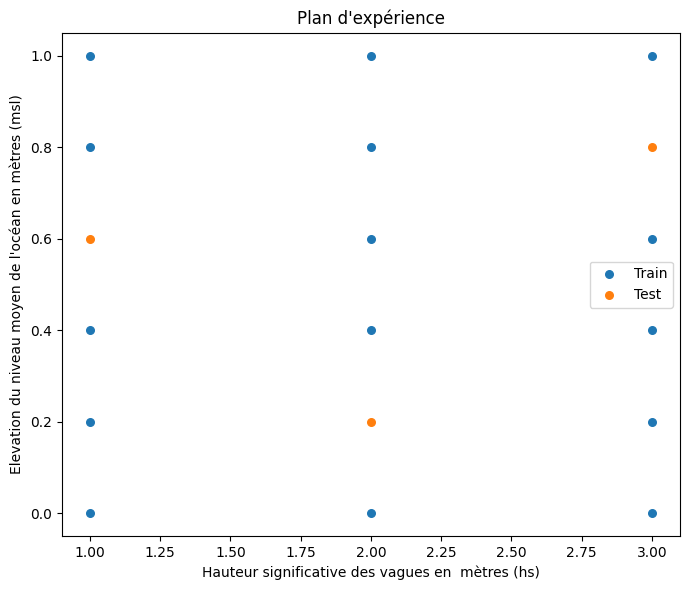

In [9]:
plt.figure(figsize=(7,6))
plt.scatter(x_train[:,0],x_train[:,1],label="Train",s=30)
plt.scatter(x_test[:,0],x_test[:,1],label="Test",s=30)
plt.xlabel("Hauteur significative des vagues en  mètres (hs)")
plt.ylabel("Elevation du niveau moyen de l'océan en mètres (msl)")
plt.title("Plan d'expérience")
plt.legend()
plt.tight_layout()
plt.show()

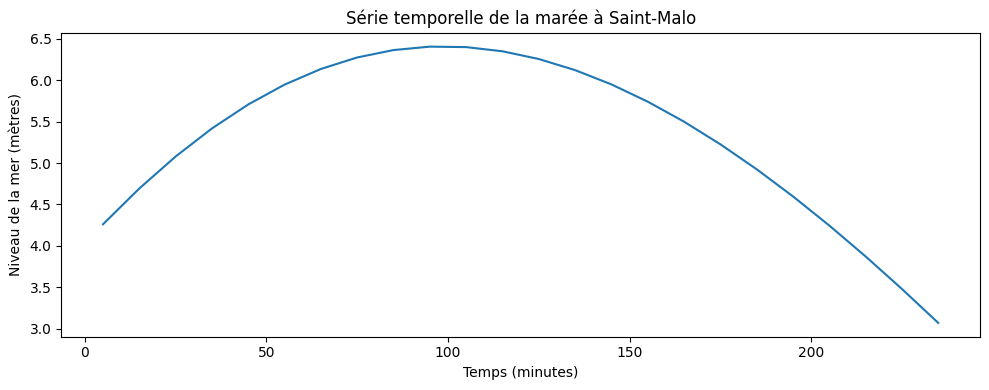

In [11]:
# On récupère les données de marée
tide = np.loadtxt("data_malo_GP_temporal/tide_timeseries.txt")
plt.figure(figsize=(10,4))
plt.plot(tide[:,0]/60, tide[:,1])
plt.xlabel("Temps (minutes)")
plt.ylabel("Niveau de la mer (mètres)")
plt.title("Série temporelle de la marée à Saint-Malo")
plt.tight_layout()
plt.show()

In [12]:
#On va transformer les données hs,msl en temporelles (fonctions constantes) et les concaténer avec la marée
def create_temporal_input(hs, msl, tide, duration=240.0, dt=10.0):
    time_vector = np.arange(10.0, duration+dt, dt)
    hs_vector = np.full_like(time_vector, hs)
    msl_vector = np.full_like(time_vector, msl)

    # On concatène les trois vecteurs
    temporal_input = np.vstack([hs_vector, msl_vector, tide[:,1]]).T
    return temporal_input

In [13]:
x_train_temporal = np.array([create_temporal_input(hs, msl, tide) for hs, msl in x_train])
x_test_temporal = np.array([create_temporal_input(hs, msl, tide) for hs, msl in x_test])

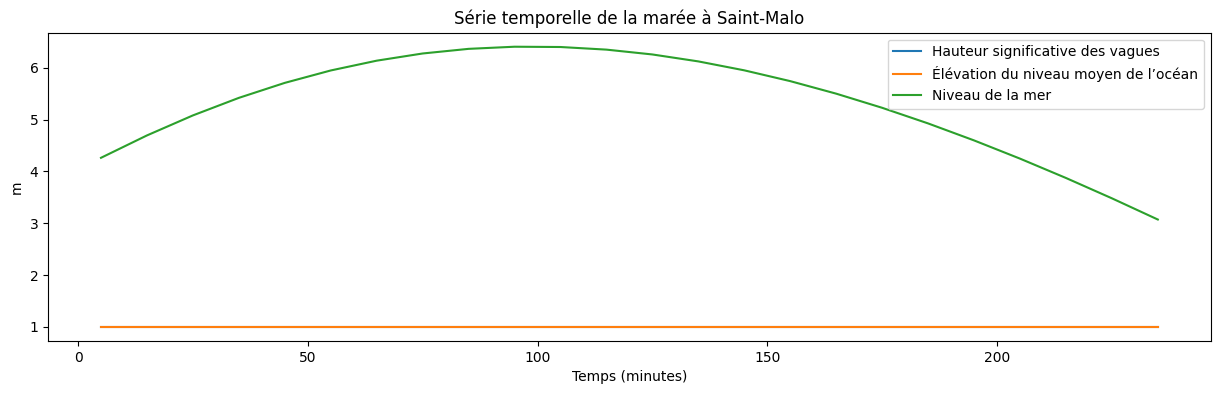

In [14]:
i = np.random.randint(15)
hs_i = x_train_temporal[i,:,0]
msl_i = x_train_temporal[i,:,1]
tide_i = x_train_temporal[i,:,2]

plt.figure(figsize=(15,4))
plt.plot(tide[:,0]/60, hs_i, label = "Hauteur significative des vagues")
plt.plot(tide[:,0]/60, msl_i, label = "Élévation du niveau moyen de l’océan")
plt.plot(tide[:,0]/60, tide_i, label = "Niveau de la mer")
plt.xlabel("Temps (minutes)")
plt.ylabel("m")
plt.title("Série temporelle de la marée à Saint-Malo")
plt.legend()
plt.show()

On va maintenant récupérer les sorties. On utilise une fonction qui récupère les sorties dans chaque dossier associé.

In [15]:
def Recuperer_data_timeseries(base_folder, x, n_timesteps=24):
    
    # 1. Récupération du nombre de cellules terrestres
    cell_info = np.fromfile("data_malo_GP_temporal/scattered_land_data.bin", dtype=">f8").reshape(-1, 5)
    n_cells = cell_info.shape[0]

    # Liste pour stocker toutes les séries temporelles H pour tous les tests
    # Chaque élément sera un tableau (T, N_cells)
    y_Hmax = []
    y_Hmoy = []

    # 2. Boucle sur les échantillons de test (hs, msl)
    for hs, msl in x:
        
        folder_name = f"run_msl_{msl:.1f}_hs_{hs:.1f}"
        sample_folder_path = os.path.join(base_folder, folder_name)
        
        # Liste pour stocker les 24 pas de temps pour cet échantillon
        Hmax= []
        Hmoy= []
        is_missing = False

        # 3. Boucle sur les 24 pas de temps
        for t in range(n_timesteps):
            
            file_name = f"scattered_map_{t:05d}.bin"
            file_path = os.path.join(sample_folder_path, file_name)

            if not os.path.exists(file_path):
                print(f"⚠️ Fichier manquant (t={t:05d}) dans :", sample_folder_path)
                # Si un fichier est manquant, on stoppe et on remplit avec NaN
                is_missing = True
                break
            
            # Lecture des données binaires
            data_t = np.fromfile(file_path, dtype=">f8").reshape(-1, 3)
            
            # Vérification de la taille des données (optionnel mais recommandé)
            if data_t.shape[0] != n_cells:
                print(f"Erreur de taille pour {file_name}. Attendu: {n_cells}, Reçu: {data_t.shape[0]}")
                is_missing = True
                break
            
            # Stockage de la hauteur H pour ce pas de temps
            Hmax.append(data_t[:,1])  # Colonne 1 : Hauteur maximale
            Hmoy.append(data_t[:,2])  # Colonne 2 : Hauteur moyenne

        if is_missing:
            Hmax = np.full(n_cells, np.nan)
            Hmoy = np.full(n_cells, np.nan)
            raise ValueError(f"Données manquantes pour l'échantillon hs={hs}, msl={msl}.")
        else:
            # Conversion de la liste de 24 arrays en un seul array (24, N_cells)
            Hmax_array = np.array(Hmax)
            Hmoy_array = np.array(Hmoy)
            
        y_Hmax.append(Hmax_array)
        y_Hmoy.append(Hmoy_array)
    
    # Conversion finale en (N_test, T, N_cells)
    y_Hmax = np.array(y_Hmax)
    y_Hmoy = np.array(y_Hmoy)

    return y_Hmax, y_Hmoy

In [16]:
#On récupère les données de sortie temporelles
y_train_Max,y_train_Moy = Recuperer_data_timeseries("data_malo_GP_temporal/Train", x_train)
y_test_Max,y_test_Moy = Recuperer_data_timeseries("data_malo_GP_temporal/Test", x_test)

On choisit de regarder la hauteur d'eau max pour la suite.

In [17]:
#On va reshape les sorties d'entrainement pour avoir (N_samples, T*N_cells)
y_train_temporal,y_test_temporal = y_train_Max.reshape(y_train_Max.shape[0],-1),y_test_Max 
print("Taille de y_train_temporal :", y_train_temporal.shape)
print("Taille de y_test_temporal :", y_test_temporal.shape)

Taille de y_train_temporal : (15, 11718960)
Taille de y_test_temporal : (3, 24, 488290)


In [18]:
n_pc = 5  # On choisit arbitrairement le nombre de composantes principales (d'après la thèse, 5 semble un bon compromis)
theta = 3 # On choisit arbitrairement la valeur de theta 
sigma = 1 # et de sigma
param = [theta, sigma]

In [19]:
# ACP ondelettes
ACP_wave = model_class.ACPF_Ondelettes(n_pc,[theta,sigma],p=0.9999,J=2)
ACP_wave.train(x_train_temporal,y_train_temporal,verbose=True)

Nombre de coefficients conservés pour l'ACP : 3718502


I0000 00:00:1766051491.394401   23957 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1079 MB memory:  -> device: 0, name: NVIDIA RTX 2000 Ada Generation, pci bus id: 0000:55:00.0, compute capability: 8.9



--- Entraînement du modèle GP pour la composante principale  1 ---
Modèle GP créé pour la composante principale  1 . Optimisation des hyperparamètres...


I0000 00:00:1766051494.377038   24713 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x385295a0


Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  2 ---
Modèle GP créé pour la composante principale  2 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  3 ---
Modèle GP créé pour la composante principale  3 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  4 ---
Modèle GP créé pour la composante principale  4 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  5 ---
Modèle GP créé pour la composante principale  5 . Optimisation des hyperparamètres...
Optimisation terminée.
--- Analyse en Composantes Principales ---
Variance expliquée par les 5 premières composantes : [0.92248213 0.05118102 0.00882079 0.00663958 0.00356886]
Variance globale expliquée : 0.9926923772464897
Taille du jeu d'entrainement transformé par ACP : (15, 5)


On regarde d'abord l'erreur sur les données d'entrainement pour vérifier qu'on interpole bien.

In [20]:
Y_train_reconstruct_ACP_wave = ACP_wave.predict(x_train_temporal)  # On prédit sur les données d'entraînement pour vérifier la reconstruction
Y_train_reconstruct_ACP_wave = Y_train_reconstruct_ACP_wave.reshape(y_train_Max.shape)

diff = Y_train_reconstruct_ACP_wave - y_train_Max
RMSE_global = np.sqrt(np.mean(diff**2))
print("RMSE sur données d'entraînement :", RMSE_global)

Prédiction en cours...
RMSE sur données d'entraînement : 0.040103368536419944


Et maintenant sur les données de test pour voir la précision de la méthode.

In [21]:
Y_test_reconstruct_ACP_wave = ACP_wave.predict(x_test_temporal)  # On prédit sur les données de test
Y_test_reconstruct_ACP_wave = Y_test_reconstruct_ACP_wave.reshape(y_test_Max.shape)

diff = Y_test_reconstruct_ACP_wave - y_test_Max
RMSE_global = np.sqrt(np.mean(diff**2))
print("RMSE sur données de test :", RMSE_global)

Prédiction en cours...
RMSE sur données de test : 0.0723227952597065


In [22]:
# --- (Fonction de mapping et de création du submesh nécessaire ici) ---
# Je vais supposer que vous avez une fonction qui retourne le submesh
# correctement initialisé et le tenseur de différences 'diff'

def create_animated_map(Y_true_series, Y_pred_series, output_filename="animation_map.gif"):
    """
    Crée une animation (GIF ou vidéo) montrant l'évolution temporelle de la
    sortie réelle (Y_true) et de la prédiction (Y_pred) côte à côte.
    
    :param Y_true_series: Tenseur de forme (T, N_cells) pour la vérité terrain.
    :param Y_pred_series: Tenseur de forme (T, N_cells) pour la prédiction
    :param output_filename: Nom du fichier de sortie (par ex. "animation.mp4" ou "animation.gif").
    """
    mesh = pv.read("data_malo_GP/gmsh_mapping.vtk")
    cell_info = np.fromfile("data_malo_GP/scattered_land_data.bin",dtype=">f8").reshape(-1, 5)
    id_gmsh = cell_info[:, 0].astype(int) - 1  

    vtk_2_gmsh = mesh.cell_data["gmsh_cell_id"].astype(int) - 1
    gmsh_2_vtk = np.empty_like(vtk_2_gmsh)
    gmsh_2_vtk[vtk_2_gmsh] = np.arange(len(vtk_2_gmsh))
    id_vtk = gmsh_2_vtk[id_gmsh]

    submesh = mesh.extract_cells(id_vtk)
    
    N_timesteps = Y_true_series.shape[0]
    
    min_val = np.nanmin(np.concatenate([Y_true_series, Y_pred_series]))
    max_val = np.nanmax(np.concatenate([Y_true_series, Y_pred_series]))
    
    # Utilisez une plage de couleurs (clim) fixe pour toute l'animation
    clim_common = [0,2]

    plotter = pv.Plotter(shape=(1, 3), off_screen=True) # off_screen=True est obligatoire pour l'enregistrement

    # --- Configuration du Plotter pour l'enregistrement ---
    # PyVista peut enregistrer en GIF (.gif) ou en vidéo (.mp4)
    if output_filename.endswith(".gif"):
        plotter.open_gif(output_filename, fps=1)
    else:
        plotter.open_movie(output_filename, framerate=10) 
        

    for t in range(N_timesteps):
        
        H_true_t = Y_true_series[t, :]
        H_pred_t = Y_pred_series[t, :]
        
        plotter.clear() # IMPORTANT : pour effacer les maillages précédents
        
        plotter.subplot(0, 0)
        
        mesh_true_t = submesh.copy()
        mesh_true_t.cell_data["H"] = H_true_t
        
        plotter.add_mesh(mesh_true_t, scalars="H", clim=clim_common, cmap="coolwarm",show_scalar_bar=False)
        plotter.view_xy()
        plotter.add_title(f"Réelle (t={t+1}/{N_timesteps})", font_size=12)

        plotter.subplot(0, 1)

        mesh_pred_t = submesh.copy()
        mesh_pred_t.cell_data["H"] = H_pred_t
        
        plotter.add_mesh(mesh_pred_t, scalars="H", clim=clim_common, cmap="coolwarm",show_scalar_bar=False)
        plotter.view_xy()
        plotter.add_title(f"Prédiction (t={t+1}/{N_timesteps})", font_size=12)
        plotter.add_scalar_bar(title="Hauteur H", interactive=False)
        
        plotter.subplot(0, 2)

        mesh_pred_t = submesh.copy()
        mesh_pred_t.cell_data["H"] =  np.abs(H_pred_t-H_true_t)/(H_true_t+1e-6)
        
        plotter.add_mesh(mesh_pred_t, scalars="H", clim=[0,1], cmap="Oranges",show_scalar_bar=False)
        plotter.view_xy()
        plotter.add_title(f"Erreur (t={t+1}/{N_timesteps})", font_size=12)
        plotter.add_scalar_bar(title='Erreur |H|',interactive=False)

        # 4. Écriture de la Frame
        plotter.write_frame()

    plotter.close()
    print(f"✅ Animation enregistrée sous : {output_filename}")

In [23]:
for i in range(y_test_Max.shape[0]):
    create_animated_map(Y_test_reconstruct_ACP_wave[i], y_test_Max[i],f"output_Malo/test_{i}.gif" )
    

✅ Animation enregistrée sous : output_Malo/test_0.gif
✅ Animation enregistrée sous : output_Malo/test_1.gif
✅ Animation enregistrée sous : output_Malo/test_2.gif


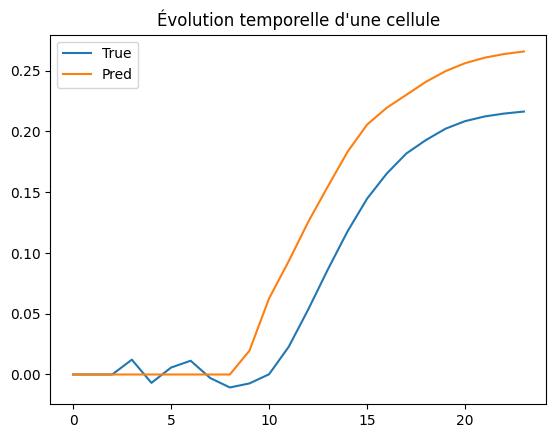

In [42]:
cell_id = np.random.randint(488290)
plt.plot(Y_test_reconstruct_ACP_wave[1, :,cell_id], label="True")
plt.plot(y_test_Max[1, :,cell_id], label="Pred")
plt.legend()
plt.title("Évolution temporelle d'une cellule")
plt.show()

On remarque que les données sautent beaucoup, c'est pour ca que les animations de sorties ne sont pas continues.